## BERT 모델

**BERT(Bidirectional Encoder Representations from Transformers)**는 문장 양방향 문맥을 동시에 보는 Transformer 인코더 전용 모델이에요. 입력 전체를 한꺼번에 보고 각 토큰의 의미를 업데이트하므로, 문장 분류·개체명 인식·질의응답 같은 이해(understanding) 작업에 특히 강합니다.

이 코드는 **QuantConnect 플랫폼**에서 실행되는 **FinBERT 기반 감정분석 트레이딩 알고리즘**입니다. HuggingFace의 사전훈련된 `ProsusAI/finbert` 모델을 사용하여 뉴스 기사의 감정을 분석하고, 이를 바탕으로 자동매매 결정을 내리는 정교한 전략을 구현합니다.

## 알고리즘 초기화 과정

`initialize()` 메서드에서는 백테스팅 기간을 2022년부터 2023년까지 1년으로 설정하고, 초기 자본을 $100,000로 지정합니다. 가장 흥미로운 부분은 **동적 유니버스 선택 로직**인데, 매월 초마다 S&P500 종목 중에서 **달러 거래량 상위 10개 종목**을 먼저 필터링한 후, 그 중에서 **변동성이 가장 높은 1개 종목**만을 선택합니다. 이는 `sorted(fundamental, key=lambda f: f.dollar_volume)[-10:]`로 유동성을 확보하고, `pct_change().iloc[1:].std().idxmax()`로 변동성을 측정하여 수익 기회를 극대화하려는 전략입니다.

## FinBERT 모델 설정과 스케줄링

알고리즘은 Transformers 라이브러리를 통해 `BertTokenizer`와 `TFBertForSequenceClassification` 모델을 로드합니다. `local_files_only=True` 옵션은 로컬에 캐시된 모델만 사용하도록 하여 네트워크 의존성을 줄입니다. `set_seed(1, True)`로 재현 가능한 결과를 보장하며, **매월 첫 거래일 자정**에 리밸런싱이 실행되도록 스케줄을 설정합니다. 30일의 워밍업 기간을 두어 충분한 데이터가 축적된 후에 거래를 시작합니다.

## 뉴스 데이터 처리와 감정분석

`_trade()` 메서드는 알고리즘의 핵심입니다. 먼저 **14일 최소 간격**을 두어 과도한 거래를 방지하고, 선택된 종목의 **최근 10일간 TiingoNews 데이터**를 수집합니다. 수집된 뉴스 기사들은 FinBERT 토크나이저를 통해 `padding=True, truncation=True` 옵션으로 전처리되어 동일한 길이로 맞춰집니다. 이후 사전훈련된 FinBERT 모델에 입력되어 **긍정/중립/부정** 3개 클래스에 대한 확률 점수를 출력합니다.

## 지수가중 집계와 매매 결정

`_aggregate_sentiment_scores()` 메서드는 여러 뉴스 기사의 감정 점수를 하나로 통합하는 정교한 로직을 구현합니다. `np.exp(np.linspace(0, 1, n))`을 사용하여 **최신 뉴스에 더 큰 가중치**를 부여하는 지수가중평균을 계산합니다. 이는 시간이 지날수록 뉴스의 영향력이 감소한다는 현실적인 가정을 반영합니다. 최종적으로 **긍정 점수가 부정 점수보다 크면 100% 롱 포지션**, 그렇지 않으면 **25% 숏 포지션**을 취하는 명확한 규칙을 적용합니다.

이 알고리즘의 강점은 **실시간 뉴스 감정분석**, **동적 유니버스 선택**, **지수가중 점수 집계** 등 여러 고급 기법을 결합하여 시장의 감정 변화를 포착하고 이를 수익으로 전환하려는 체계적인 접근방식에 있습니다.

In [ ]:
# region imports
from AlgorithmImports import *

import tensorflow as tf
from transformers import TFBertForSequenceClassification, BertTokenizer, set_seed
from pathlib import Path
# endregion

class FinbertBaseModelAlgorithm(QCAlgorithm):
    """
    FinBERT 기반 감정분석 트레이딩 알고리즘
    
    이 알고리즘은 HuggingFace의 사전훈련된 "ProsusAI/finbert" 모델을 사용하여
    뉴스 기사의 감정(긍정/중립/부정)을 분석하고, 이를 바탕으로 자동매매를 수행합니다.
    
    전략 개요:
    1. 매월 초 S&P500에서 유동성 상위 10개 종목 선별
    2. 그 중 변동성이 가장 높은 1개 종목만 거래 대상으로 선택
    3. 최근 10일간 뉴스를 FinBERT로 감정분석
    4. 지수가중평균으로 감정점수 집계
    5. 긍정>부정이면 100% 롱, 아니면 25% 숏 포지션
    """

    def initialize(self):
        """
        알고리즘 초기화 메서드
        백테스팅 설정, 유니버스 정의, 모델 로딩, 스케줄링 등을 수행
        """
        # 백테스팅 기간 설정 (2022년 1년간)
        self.set_start_date(2022, 1, 1)
        self.set_end_date(2023, 1, 1)
        self.set_cash(100_000)  # 초기 자본금 $100,000

        # 유니버스 선택을 위한 기준 심볼 (SPY ETF 사용)
        spy = Symbol.create("SPY", SecurityType.EQUITY, Market.USA)
        self.universe_settings.resolution = Resolution.DAILY  # 일간 데이터 해상도
        # 매월 첫 거래일에 유니버스 재선택
        self.universe_settings.schedule.on(self.date_rules.month_start(spy))
        
        # 동적 유니버스 선택 로직
        # 1단계: 달러 거래량 기준 상위 10개 종목 선별
        # 2단계: 그 중 1년간 일간 수익률 변동성이 가장 높은 종목 1개 선택
        self._universe = self.add_universe(
            lambda fundamental: [
                self.history(
                    [
                        f.symbol 
                        for f in sorted(
                            fundamental, key=lambda f: f.dollar_volume  # 달러 거래량 오름차순 정렬
                        )[-10:]  # 상위 10개 선택
                    ], 
                    timedelta(365), Resolution.DAILY  # 1년간 일간 데이터
                )['close'].unstack(0)  # 종목별 종가 데이터를 열로 변환
                .pct_change()  # 일간 수익률 계산
                .iloc[1:]  # 첫 번째 NaN 값 제거
                .std()  # 각 종목의 수익률 표준편차(변동성) 계산
                .idxmax()  # 변동성이 가장 높은 종목의 심볼 반환
            ]
        )
        
        # 재현 가능한 결과를 위한 시드 고정
        # 두 번째 파라미터 True는 deterministic 모드 활성화
        set_seed(1, True)
        
        # FinBERT 토크나이저와 모델 로드
        model_path = "ProsusAI/finbert"
        # local_files_only=True: 로컬 캐시된 모델만 사용 (네트워크 의존성 제거)
        self._tokenizer = BertTokenizer.from_pretrained(model_path, local_files_only=True)
        self._model = TFBertForSequenceClassification.from_pretrained(model_path, local_files_only=True)
        
        # 리밸런싱 스케줄 설정
        self._last_rebalance_time = datetime.min  # 마지막 리밸런싱 시간 추적
        self.schedule.on(
            self.date_rules.month_start(spy, 1),  # 매월 첫 거래일
            self.time_rules.midnight,  # 자정에 실행
            self._trade  # 실행할 메서드
        )
        
        # 30일 워밍업 기간 설정 (충분한 데이터 축적을 위해)
        self.set_warm_up(timedelta(30))

    def on_warmup_finished(self):
        """
        워밍업 기간 완료 후 첫 거래 실행
        """
        self._trade()

    def on_securities_changed(self, changes):
        """
        유니버스 변경 시 호출되는 이벤트 핸들러
        제거된 종목의 뉴스 데이터 구독 해제, 추가된 종목의 뉴스 데이터 구독
        """
        # 유니버스에서 제거된 종목들의 뉴스 데이터 구독 해제
        for security in changes.removed_securities:
            self.remove_security(security.dataset_symbol)
        
        # 유니버스에 추가된 종목들의 TiingoNews 데이터 구독
        for security in changes.added_securities:
            security.dataset_symbol = self.add_data(TiingoNews, security.symbol).symbol

    def _trade(self):
        """
        핵심 거래 로직 메서드
        뉴스 데이터 수집 → 감정분석 → 포지션 결정 과정을 수행
        """
        # 거래 조건 확인: 워밍업 중이거나 마지막 리밸런싱 후 14일 미만이면 거래 중단
        if self.is_warming_up or self.time - self._last_rebalance_time < timedelta(14):
            return

        # 현재 선택된 거래 대상 종목 가져오기
        security = self.securities[list(self._universe.selected)[0]]

        # 최근 10일간 뉴스 기사 데이터 수집
        articles = self.history[TiingoNews](security.dataset_symbol, 10, Resolution.DAILY)
        article_text = [article.description for article in articles]  # 기사 본문만 추출
        
        # 뉴스 기사가 없으면 거래 중단
        if not article_text:
            return

        # FinBERT 토크나이저로 입력 텍스트 전처리
        # padding=True: 배치 내 모든 시퀀스를 동일한 길이로 패딩
        # truncation=True: 최대 길이 초과 시 자르기
        # return_tensors='tf': TensorFlow 텐서 형태로 반환
        inputs = self._tokenizer(article_text, padding=True, truncation=True, return_tensors='tf')

        # FinBERT 모델로 감정분석 추론 실행
        outputs = self._model(**inputs)

        # 모델 출력(로짓)에 소프트맥스 적용하여 확률값으로 변환
        # axis=-1: 마지막 차원(클래스 차원)에 대해 소프트맥스 적용
        scores = tf.nn.softmax(outputs.logits, axis=-1).numpy()
        self.log(f"{str(scores)}")  # 디버깅용 점수 로그
        
        # 여러 기사의 감정점수를 지수가중평균으로 집계
        scores = self._aggregate_sentiment_scores(scores)
        
        # 감정 확률을 차트에 플롯 (시각화)
        self.plot("Sentiment Probability", "Negative", scores[0])   # 부정 확률
        self.plot("Sentiment Probability", "Neutral", scores[1])    # 중립 확률
        self.plot("Sentiment Probability", "Positive", scores[2])   # 긍정 확률

        # 포지션 결정 로직
        # 긍정 점수 > 부정 점수 → 100% 롱 포지션
        # 그 외의 경우 → 25% 숏 포지션
        weight = 1 if scores[2] > scores[0] else -0.25
        
        # 포트폴리오 리밸런싱 실행
        # 세 번째 파라미터 True는 기존 포지션을 청산하고 새로 진입
        self.set_holdings(security.symbol, weight, True)
        self._last_rebalance_time = self.time  # 리밸런싱 시간 업데이트

    def _aggregate_sentiment_scores(self, sentiment_scores):
        """
        여러 뉴스 기사의 감정점수를 지수가중평균으로 집계하는 메서드
        
        Args:
            sentiment_scores: 각 기사별 감정점수 배열 (n개 기사 × 3개 클래스)
        
        Returns:
            aggregated_scores: 집계된 감정점수 (3개 클래스)
        """
        n = sentiment_scores.shape[0]  # 뉴스 기사 개수
        
        # 지수적으로 증가하는 가중치 생성 (최신 뉴스에 더 큰 가중치)
        # linspace(0, 1, n): 0부터 1까지 n개의 등간격 값 생성
        # exp(): 지수함수 적용으로 최신 기사일수록 높은 가중치
        weights = np.exp(np.linspace(0, 1, n))
        
        # 가중치 정규화 (총합이 1이 되도록)
        weights /= weights.sum()
        
        # 감정점수에 가중치 적용
        # weights[:, np.newaxis]: (n,) → (n, 1) 형태로 브로드캐스팅
        # sentiment_scores: (n, 3) 형태
        weighted_scores = sentiment_scores * weights[:, np.newaxis]
        
        # 가중 점수들을 합산하여 최종 집계 점수 계산
        # axis=0: 기사 차원(첫 번째 차원)을 따라 합산
        aggregated_scores = weighted_scores.sum(axis=0)
        
        return aggregated_scores

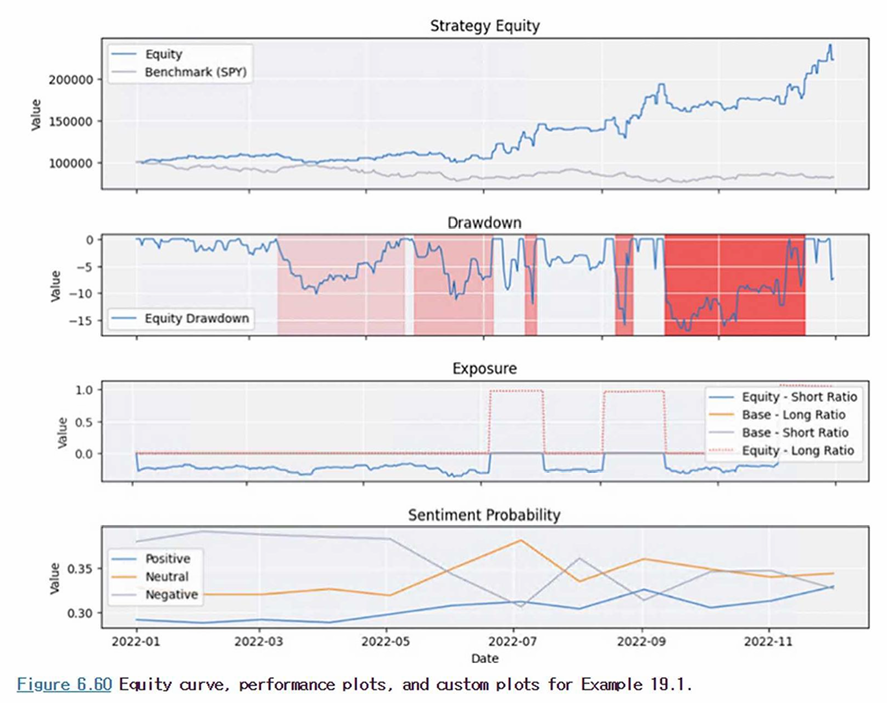

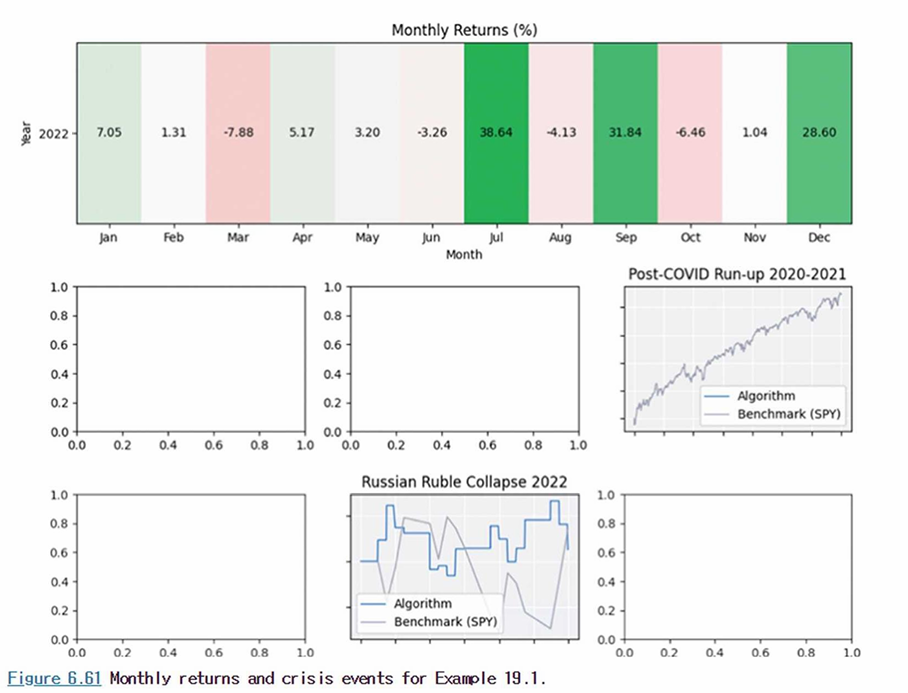

In [ ]:
# region imports
from AlgorithmImports import *

import tensorflow as tf
from transformers import TFBertForSequenceClassification, BertTokenizer, set_seed
from pathlib import Path
from datasets import Dataset  # HuggingFace 데이터셋 라이브러리
import pytz  # 시간대 변환을 위한 라이브러리
# endregion

class FinbertBaseModelAlgorithm(QCAlgorithm):
    """
    FinBERT 파인튜닝 기반 감정분석 트레이딩 알고리즘
    
    이 알고리즘은 HuggingFace의 사전훈련된 "ProsusAI/finbert" 모델을 매월 실제 시장 데이터로
    파인튜닝하여 뉴스 기사의 감정을 분석하고, 이를 바탕으로 자동매매를 수행합니다.
    
    핵심 차이점 (이전 버전 대비):
    1. 매월 초 최근 30일간 뉴스-수익률 데이터로 모델 파인튜닝
    2. 연속된 뉴스 발표 간 자산 수익률을 레이블로 사용
    3. 상위/하위 75% 수익률을 긍정/부정으로 분류하여 학습
    4. 실시간 적응형 모델로 시장 변화에 동적 대응
    """

    def initialize(self):
        """
        알고리즘 초기화 메서드
        백테스팅 설정, 유니버스 정의, 모델 설정, 스케줄링 등을 수행
        """
        # 백테스팅 기간 설정 (2022년 1년간)
        self.set_start_date(2022, 1, 1)
        self.set_end_date(2023, 1, 1)
        self.set_cash(100_000)  # 초기 자본금 $100,000

        # 유니버스 선택을 위한 기준 심볼 (SPY ETF 사용)
        spy = Symbol.create("SPY", SecurityType.EQUITY, Market.USA)
        self.universe_settings.resolution = Resolution.DAILY  # 일간 데이터 해상도
        # 매월 첫 거래일에 유니버스 재선택
        self.universe_settings.schedule.on(self.date_rules.month_start(spy))
        
        # 동적 유니버스 선택 로직 (이전 버전과 동일)
        # 1단계: 달러 거래량 기준 상위 10개 종목 선별
        # 2단계: 그 중 1년간 일간 수익률 변동성이 가장 높은 종목 1개 선택
        self._universe = self.add_universe(
            lambda fundamental: [
                self.history(
                    [
                        f.symbol 
                        for f in sorted(
                            fundamental, key=lambda f: f.dollar_volume  # 달러 거래량 오름차순 정렬
                        )[-10:]  # 상위 10개 선택
                    ], 
                    timedelta(365), Resolution.DAILY  # 1년간 일간 데이터
                )['close'].unstack(0)  # 종목별 종가 데이터를 열로 변환
                .pct_change()  # 일간 수익률 계산
                .iloc[1:]  # 첫 번째 NaN 값 제거
                .std()  # 각 종목의 수익률 표준편차(변동성) 계산
                .idxmax()  # 변동성이 가장 높은 종목의 심볼 반환
            ]
        )
        
        # 재현 가능한 결과를 위한 시드 고정
        set_seed(1, True)
        
        # 리밸런싱 스케줄 설정
        self._last_rebalance_time = datetime.min  # 마지막 리밸런싱 시간 추적
        self.schedule.on(
            self.date_rules.month_start(spy, 1),  # 매월 첫 거래일
            self.time_rules.midnight,  # 자정에 실행
            self._trade  # 실행할 메서드
        )
        
        # 30일 워밍업 기간 설정 (충분한 데이터 축적을 위해)
        self.set_warm_up(timedelta(30))
        
        # 모델 설정 및 토크나이저 로드
        self._model_name = "ProsusAI/finbert"  # 사전훈련된 FinBERT 모델 경로
        # 토크나이저만 미리 로드 (모델은 매번 새로 로드하여 파인튜닝)
        self._tokenizer = BertTokenizer.from_pretrained(self._model_name)

    def on_warmup_finished(self):
        """
        워밍업 기간 완료 후 첫 거래 실행
        """
        self._trade()

    def on_securities_changed(self, changes):
        """
        유니버스 변경 시 호출되는 이벤트 핸들러
        제거된 종목의 뉴스 데이터 구독 해제, 추가된 종목의 뉴스 데이터 구독
        """
        # 유니버스에서 제거된 종목들의 뉴스 데이터 구독 해제
        for security in changes.removed_securities:
            self.remove_security(security.dataset_symbol)
        
        # 유니버스에 추가된 종목들의 TiingoNews 데이터 구독
        for security in changes.added_securities:
            security.dataset_symbol = self.add_data(
                TiingoNews, security.symbol
            ).symbol

    def _trade(self):
        """
        핵심 거래 로직 메서드
        훈련 데이터 수집 → 모델 파인튜닝 → 감정분석 → 포지션 결정 과정을 수행
        """
        # 거래 조건 확인: 워밍업 중이거나 마지막 리밸런싱 후 14일 미만이면 거래 중단
        if (self.is_warming_up or 
            self.time - self._last_rebalance_time < timedelta(14)):
            return

        # 현재 선택된 거래 대상 종목 가져오기
        security = self.securities[list(self._universe.selected)[0]]

        # 파인튜닝을 위한 샘플 데이터 수집
        samples = pd.DataFrame(columns=['text', 'label'])  # 텍스트와 레이블을 저장할 DataFrame
        
        # 최근 30일간 뉴스 기사 데이터 수집
        news_history = self.history(security.dataset_symbol, 30, Resolution.DAILY)
        if news_history.empty:
            return
        # 뉴스 기사의 설명(description) 부분만 추출
        news_history = news_history.loc[security.dataset_symbol]['description']
        
        # 같은 기간의 자산 가격 데이터 수집 (초 단위 해상도로 정밀한 타이밍 분석)
        asset_history = self.history(
            security.symbol, timedelta(30), Resolution.SECOND
        ).loc[security.symbol]['close']
        
        # 연속된 뉴스 발표 간의 자산 수익률을 레이블로 생성
        for i in range(len(news_history.index)-1):
            # 현재 뉴스 기사의 본문 텍스트 추출
            factor = news_history.iloc[i]
            if not factor:  # 빈 기사는 건너뛰기
                continue

            # 레이블 생성: 뉴스 발표 후 다음 뉴스 발표까지의 시장 반응(수익률) 계산
            release_time = self._convert_to_eastern(news_history.index[i])      # 현재 뉴스 발표 시간
            next_release_time = self._convert_to_eastern(news_history.index[i+1])  # 다음 뉴스 발표 시간
            
            # 두 뉴스 발표 시간 사이의 가격 데이터 추출
            reaction_period = asset_history[
                (asset_history.index > release_time) &
                (asset_history.index < next_release_time + timedelta(seconds=1))
            ]
            if reaction_period.empty:  # 해당 기간에 가격 데이터가 없으면 건너뛰기
                continue
            
            # 수익률 계산: (마지막 가격 - 첫 가격) / 첫 가격
            label = (
                (reaction_period.iloc[-1] - reaction_period.iloc[0]) 
                / reaction_period.iloc[0]
            )
            
            # 훈련 샘플로 저장 (뉴스 텍스트, 해당 기간 수익률)
            samples.loc[len(samples), :] = [factor, label]

        # 최근 100개 샘플만 사용 (메모리 효율성 및 최신 데이터 중심)
        samples = samples.iloc[-100:]
        
        # 최소 10개 샘플이 없으면 모든 포지션 청산하고 거래 중단
        if samples.shape[0] < 10:
            self.liquidate()
            return
        
        # 연속 수익률을 3개 클래스로 분류
        # 상위 75% 긍정 수익률 → 클래스 2 (긍정)
        # 하위 75% 부정 수익률 → 클래스 0 (부정)  
        # 나머지 → 클래스 1 (중립)
        sorted_samples = samples.sort_values(
            by='label', ascending=False  # 수익률 내림차순 정렬
        ).reset_index(drop=True)
        
        percent_signed = 0.75  # 상위/하위 75% 기준
        
        # 긍정 수익률 중 상위 75%의 cutoff 인덱스 계산
        positive_cutoff = (
            int(percent_signed 
            * len(sorted_samples[sorted_samples.label > 0]))
        )
        
        # 부정 수익률 중 하위 75%의 cutoff 인덱스 계산
        negative_cutoff = (
            len(sorted_samples) 
            - int(percent_signed * len(sorted_samples[sorted_samples.label < 0]))
        )
        
        # 레이블 재할당
        sorted_samples.loc[
            list(range(negative_cutoff, len(sorted_samples))), 'label'
        ] = 0  # 하위 75% 부정 수익률 → 클래스 0 (부정)
        
        sorted_samples.loc[
            list(range(positive_cutoff, negative_cutoff)), 'label'
        ] = 1  # 중간 구간 → 클래스 1 (중립)
        
        sorted_samples.loc[list(range(0, positive_cutoff)), 'label'] = 2  # 상위 75% 긍정 수익률 → 클래스 2 (긍정)

        # 사전훈련된 FinBERT 모델 로드 (매번 새로 로드하여 파인튜닝)
        model = TFBertForSequenceClassification.from_pretrained(
            self._model_name, 
            num_labels=3,      # 3개 클래스 (부정/중립/긍정)
            from_pt=True       # PyTorch 가중치에서 TensorFlow로 변환
        )
        
        # 모델 컴파일 설정
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),  # Adam 옵티마이저, 낮은 학습률
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)  # 다중클래스 분류 손실함수
        )
        
        # HuggingFace Dataset 형태로 훈련 데이터 변환
        dataset = Dataset.from_pandas(sorted_samples)
        
        # 토크나이징 적용 (텍스트를 모델 입력 형태로 변환)
        dataset = dataset.map(
            lambda sample: self._tokenizer(
                sample['text'], 
                padding='max_length',  # 최대 길이로 패딩
                truncation=True        # 최대 길이 초과 시 자르기
            )
        )
        
        # TensorFlow 데이터셋으로 변환 (모델 훈련에 적합한 형태)
        dataset = model.prepare_tf_dataset(
            dataset, 
            shuffle=True,              # 데이터 섞기
            tokenizer=self._tokenizer  # 토크나이저 설정
        )
        
        # 모델 파인튜닝 실행 (2 에포크)
        model.fit(dataset, epochs=2)
        
        # 추론을 위한 입력 데이터 준비 (최근 뉴스들)
        inputs = self._tokenizer(
            list(samples['text'].values), 
            padding=True, 
            truncation=True, 
            return_tensors='tf'  # TensorFlow 텐서 형태로 반환
        )

        # 파인튜닝된 모델로 감정분석 추론 실행
        outputs = model(**inputs)

        # 모델 출력(로짓)에 소프트맥스 적용하여 확률값으로 변환
        scores = tf.nn.softmax(outputs.logits, axis=-1).numpy()
        
        # 여러 기사의 감정점수를 지수가중평균으로 집계
        scores = self._aggregate_sentiment_scores(scores)
        
        # 감정 확률을 차트에 플롯 (시각화)
        self.plot("Sentiment Probability", "Negative", scores[0])   # 부정 확률
        self.plot("Sentiment Probability", "Neutral", scores[1])    # 중립 확률
        self.plot("Sentiment Probability", "Positive", scores[2])   # 긍정 확률

        # 포지션 결정 로직 (이전 버전과 동일)
        # 긍정 점수 > 부정 점수 → 100% 롱 포지션
        # 그 외의 경우 → 25% 숏 포지션
        weight = 1 if scores[2] > scores[0] else -0.25
        
        # 포트폴리오 리밸런싱 실행
        self.set_holdings(security.symbol, weight, True)
        self._last_rebalance_time = self.time  # 리밸런싱 시간 업데이트

    def _convert_to_eastern(self, dt):
        """
        UTC 시간을 미국 동부 시간(Eastern Time)으로 변환하는 유틸리티 메서드
        
        Args:
            dt: UTC 시간 객체
            
        Returns:
            동부 시간으로 변환된 naive datetime 객체
        """
        # UTC 시간을 동부 시간으로 변환 후 시간대 정보 제거
        return dt.astimezone(pytz.timezone('US/Eastern')).replace(tzinfo=None)

    def _aggregate_sentiment_scores(self, sentiment_scores):
        """
        여러 뉴스 기사의 감정점수를 지수가중평균으로 집계하는 메서드
        (이전 버전과 동일한 로직)
        
        Args:
            sentiment_scores: 각 기사별 감정점수 배열 (n개 기사 × 3개 클래스)
        
        Returns:
            aggregated_scores: 집계된 감정점수 (3개 클래스)
        """
        n = sentiment_scores.shape[0]  # 뉴스 기사 개수
        
        # 지수적으로 증가하는 가중치 생성 (최신 뉴스에 더 큰 가중치)
        weights = np.exp(np.linspace(0, 1, n))
        
        # 가중치 정규화 (총합이 1이 되도록)
        weights /= weights.sum()
        
        # 감정점수에 가중치 적용
        weighted_scores = sentiment_scores * weights[:, np.newaxis]
        
        # 가중 점수들을 합산하여 최종 집계 점수 계산
        aggregated_scores = weighted_scores.sum(axis=0)
        
        return aggregated_scores

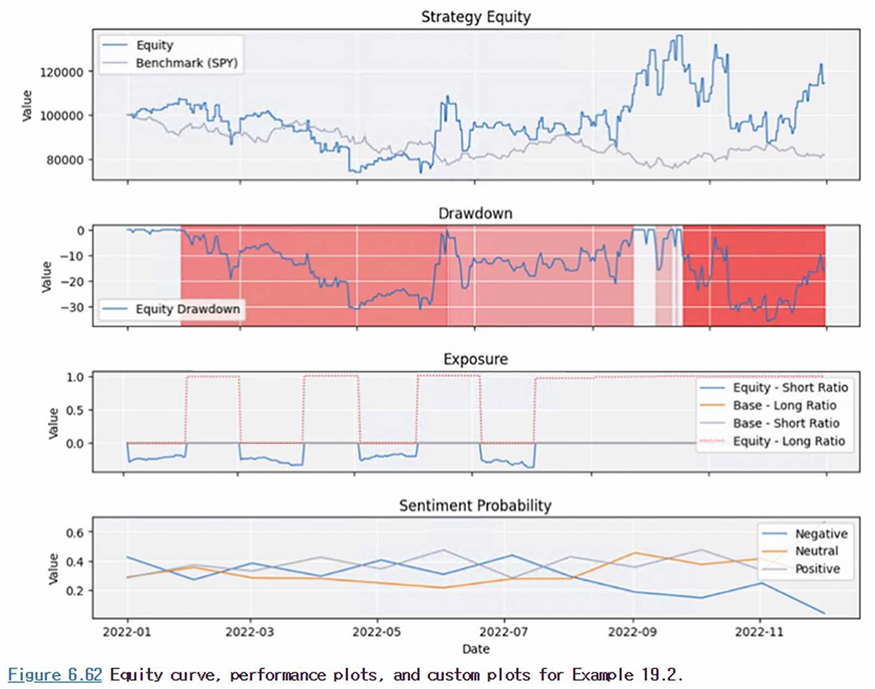

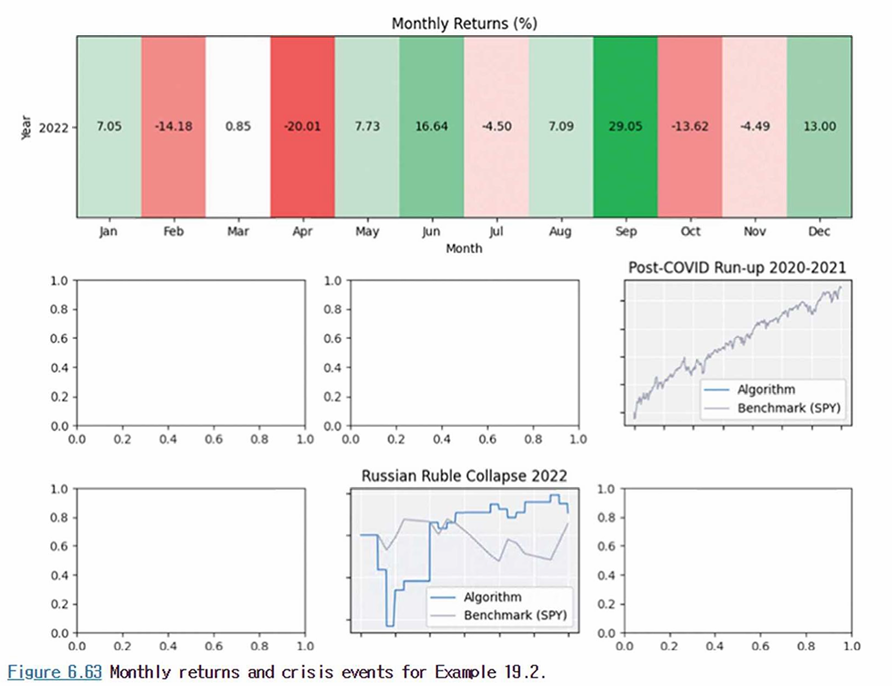

이 파인튜닝 버전의 핵심 차이점과 장점:

1. 적응형 학습
    - 매월 최근 30일간의 실제 시장 반응 데이터로 모델을 재훈련
    - 시장 환경 변화에 동적으로 적응하는 능력

2. 실제 라벨링
    - 연속된 뉴스 발표 간 자산 수익률을 라벨로 사용
    - 상위/하위 75% 기준으로 긍정/부정 분류하여 현실적인 학습

3. 정밀한 타이밍
    - 초 단위 가격 데이터로 뉴스 발표 후 정확한 시장 반응 측정
    - 동부 시간대 변환으로 뉴스 발표 시간 정확성 확보

4. 메모리 효율성
    - 최근 100개 샘플만 사용하여 계산 부담 감소
    - 최신 데이터에 집중하여 트렌드 변화 신속 포착
    - 이 접근법은 정적 모델보다 시장 변화에 더 민감하게 반응할 수 있는 고급 전략입니다.